# Mosaic + Medical Imaging

# Setup

In [9]:
#!pip install -q git+https://github.com/robustness-gym/mosaic@dev[medimg,text]
#!pip install -q torchxrayvision
#!python3 -m spacy download en_core_web_sm

import mosaic.version as mversion
import torch
print("mosaic version: ", mversion.__version__)
print("torch version: ", torch.__version__)

mosaic version:  0.0.2
torch version:  1.8.1


In [2]:
%load_ext autoreload
%autoreload 2

import os
import mosaic as ms
import numpy as np
import matplotlib.pyplot as plt
import torchxrayvision as xrv

# Uncomment the line below to see whats going on under the hood
# logging.getLogger("mosaic").setLevel(logging.INFO)

## 💾 Downloading the data
We'll be using the dataset from the [SIIM-ACR Pneumothorax Segmentation Challenge](https://www.kaggle.com/c/siim-acr-pneumothorax-segmentation/data) (`mosaic.contrib.siim_cxr` provides utility functions for downloading the data). The downloaded dataset includes the inputs, a large number of chest x-ray files stored in [DICOM](https://www.dicomstandard.org/) format, and the targets, a CSV file mapping each file to its binary pneumothorax label.
-  Download time: ~2 minutes
- Download size:  2.0 GB

In [41]:
from mosaic.contrib.siim_cxr import download_siim_cxr
dataset_dir = "/Users/sabrieyuboglu/data/datasets/siim-cxr"
download_siim_cxr(
    dataset_dir, 
    "sabrieyuboglu", 
    "8124277674a280e445d0c7c0ed769fd3"
)

## 🔨 Building a `DataPanel`

In [4]:
dp = ms.DataPanel.from_csv(os.path.join(dataset_dir, "siim_cxr.csv"))
dp.head()

,image_id (NumpyArrayColumn),encoded_pixels (NumpyArrayColumn),pmx (NumpyArrayColumn),filepath (NumpyArrayColumn),report (NumpyArrayColumn),index (ListColumn)
0,1.2.276.0.7230010.3.1.4.8323329.6904.151787520...,-1,0,/Users/sabrieyuboglu/data/datasets/siim-cxr/si...,The upper lungs are clear. Right lower lobe op...,'0'
1,1.2.276.0.7230010.3.1.4.8323329.13666.15178752...,557374 2 1015 8 1009 14 1002 20 997 26 990 32 ...,1,/Users/sabrieyuboglu/data/datasets/siim-cxr/si...,The upper lungs are clear. Right lower lobe op...,'1'
2,1.2.276.0.7230010.3.1.4.8323329.11028.15178752...,-1,0,/Users/sabrieyuboglu/data/datasets/siim-cxr/si...,The upper lungs are clear. Right lower lobe op...,'2'
3,1.2.276.0.7230010.3.1.4.8323329.10366.15178752...,514175 10 1008 29 994 30 993 32 991 33 990 34 ...,1,/Users/sabrieyuboglu/data/datasets/siim-cxr/si...,Cardiac size cannot be evaluated. Large left p...,'3'
4,1.2.276.0.7230010.3.1.4.8323329.10016.15178752...,592184 33 976 58 956 73 941 88 926 102 917 109...,1,/Users/sabrieyuboglu/data/datasets/siim-cxr/si...,The upper lungs are clear. Right lower lobe op...,'4'


So far, the DataPanel isn't providing anything we couldn't get with a Pandas `DataFrame` because the columns in the CSV include only strings and numbers. 

Things get interesting when we start adding columns for objects that don't play nicely with Pandas – things like images, text, time-series, videos, and multi-dimensional arrays. Out-of-the-box, Mosaic comes with a number of common column types including `ImageColumn` for images, `VideoColumn` for videos, `NumpyArrayColumn` for (potentially multi-dimensional) NumPy `ndarray`s, and `TensorColumn` for PyTorch Tensors (see [here](https://github.com/robustness-gym/mosaic/blob/dev/README.md#supported-columns) for a full list of core columns).  

To house the X-rays in the dataset, we'll be using the `MedicalVolumeColumn`, a column type similar to `ImageColumn` but optimized for medical images stored in [DICOM format](https://www.dicomstandard.org/). 

In [5]:
# Make a column of MedicalVolumeCells
from dosma import DicomReader
from mosaic.contrib.siim_cxr import cxr_transform, cxr_transform_pil

loader = DicomReader(group_by=None, default_ornt=("SI", "AP"))
dp["img"] = ms.MedicalVolumeColumn.from_filepaths(
    dp["filepath"], loader=loader, transform=cxr_transform_pil
)
dp["input"] = ms.MedicalVolumeColumn.from_filepaths(
    dp["filepath"], loader=loader, transform=cxr_transform
)

## 📄 Adding in metadata

In [8]:
def unroll_metadata(dp):
    img = dp["img"]
    if img.get_metadata() is None:
      _ = img.get()  # load dicom to get metadata

    md = img.get_metadata(as_raw_type=True, readable=True, ignore_bytes=True)

    # image metadata can be quite large, flush to avoid RAM overload
    img._metadata = None
    return md

dp = dp.update(unroll_metadata, materialize=False, pbar=True)
dp.head()

100%|██████████| 12047/12047 [02:28<00:00, 81.33it/s]


,image_id (NumpyArrayColumn),encoded_pixels (NumpyArrayColumn),pmx (NumpyArrayColumn),filepath (NumpyArrayColumn),report (NumpyArrayColumn),index (ListColumn),img (CellColumn),img_tensor (CellColumn),Specific Character Set (ListColumn),SOP Class UID (ListColumn),...,Photometric Interpretation (ListColumn),Rows (NumpyArrayColumn),Columns (NumpyArrayColumn),Pixel Spacing (ListColumn),Bits Allocated (NumpyArrayColumn),Bits Stored (NumpyArrayColumn),High Bit (NumpyArrayColumn),Pixel Representation (NumpyArrayColumn),Lossy Image Compression (ListColumn),Lossy Image Compression Method (ListColumn)
0,1.2.276.0.7230010.3.1.4.8323329.6904.151787520...,-1,0,/Users/sabrieyuboglu/data/datasets/siim-cxr/si...,The upper lungs are clear. Right lower lobe op...,'0',MedicalVolumeCell([PosixPath('/Users/sabrieyub...,MedicalVolumeCell([PosixPath('/Users/sabrieyub...,'ISO_IR 100','1.2.840.10008.5.1.4.1.1.7',...,'MONOCHROME2',1024,1024,"[""0.168"", ""0.168""]",8,8,7,0,'01','ISO_10918_1'
1,1.2.276.0.7230010.3.1.4.8323329.13666.15178752...,557374 2 1015 8 1009 14 1002 20 997 26 990 32 ...,1,/Users/sabrieyuboglu/data/datasets/siim-cxr/si...,Cardiac size cannot be evaluated. Large left p...,'1',MedicalVolumeCell([PosixPath('/Users/sabrieyub...,MedicalVolumeCell([PosixPath('/Users/sabrieyub...,'ISO_IR 100','1.2.840.10008.5.1.4.1.1.7',...,'MONOCHROME2',1024,1024,"[""0.139"", ""0.139""]",8,8,7,0,'01','ISO_10918_1'
2,1.2.276.0.7230010.3.1.4.8323329.11028.15178752...,-1,0,/Users/sabrieyuboglu/data/datasets/siim-cxr/si...,Cardiac size cannot be evaluated. Large left p...,'2',MedicalVolumeCell([PosixPath('/Users/sabrieyub...,MedicalVolumeCell([PosixPath('/Users/sabrieyub...,'ISO_IR 100','1.2.840.10008.5.1.4.1.1.7',...,'MONOCHROME2',1024,1024,"[""0.14300000000000002"", ""0.14300000000000002""]",8,8,7,0,'01','ISO_10918_1'
3,1.2.276.0.7230010.3.1.4.8323329.10366.15178752...,514175 10 1008 29 994 30 993 32 991 33 990 34 ...,1,/Users/sabrieyuboglu/data/datasets/siim-cxr/si...,Cardiac size cannot be evaluated. Large left p...,'3',MedicalVolumeCell([PosixPath('/Users/sabrieyub...,MedicalVolumeCell([PosixPath('/Users/sabrieyub...,'ISO_IR 100','1.2.840.10008.5.1.4.1.1.7',...,'MONOCHROME2',1024,1024,"[""0.139"", ""0.139""]",8,8,7,0,'01','ISO_10918_1'
4,1.2.276.0.7230010.3.1.4.8323329.10016.15178752...,592184 33 976 58 956 73 941 88 926 102 917 109...,1,/Users/sabrieyuboglu/data/datasets/siim-cxr/si...,Cardiac size cannot be evaluated. Large left p...,'4',MedicalVolumeCell([PosixPath('/Users/sabrieyub...,MedicalVolumeCell([PosixPath('/Users/sabrieyub...,'ISO_IR 100','1.2.840.10008.5.1.4.1.1.7',...,'MONOCHROME2',1024,1024,"[""0.139"", ""0.139""]",8,8,7,0,'01','ISO_10918_1'


### 💫 Computing model predictions and activations.
We'd like to perform inference and extract:
  
1. Output predictions  
2. Output class probabilities  
3. Model activations 

Note: in order to extract model activations, we'll need to use a [PyTorch forward hook](https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html#forward-and-backward-function-hooks) and register it on the final layer of the ResNet. Forward hooks are just functions that get executed on the forward pass of a `torch.nn.Module`. 

In [ ]:
model = xrv.models.DenseNet(weights="chex").to("cuda")
model.eval()

# 2. Register the forward hook
embedding = None
def forward_hook(module, input, output):
  global embedding
  embedding = output

model.features.register_forward_hook(forward_hook)

In [ ]:
import torch
from mosaic.columns.prediction_column import ClassificationOutputColumn

@torch.no_grad()
def predict(batch: ms.DataPanel):
  global embedding

  x = batch["img_tensor"].data[:, :1, ...]
  x = x.to("cuda")  # We get the underlying torch tensor with `data` and move to GPU 
  probs = model(x)  # Run forward pass

  # Returning numpy for now to test memmap
  return {
      "output": ms.NumpyArrayColumn(probs=probs.cpu()),
      "embedding": ms.NumpyArrayColumn(embedding.mean(dim=[-1,-2]).cpu())
  }
  # return {
  #     "output": ClassificationOutputColumn(probs=probs.cpu(), multi_label=True),
  #     "embedding": ms.EmbeddingColumn(embedding.mean(dim=[-1,-2]).cpu())
  # }


dp = dp_train.copy()
dp.remove_column("img")
dp = dp.update(
  function=predict, is_batched_fn=True, batch_size=16,
  num_workers=0, pbar=True, mmap=True
)
dp.head()

dp["Correct"] = dp["pmx"] == dp["output"].preds
dp.head()

### 📄 Radiologist reports (`SpacyColumn`)

In pneuomothorax detection, as in other classification tasks, the binary label does not capture all of the nuance in the X-ray. Radiologists communicate that additional detail via natural language radiologist reports that accompany each scan. For example, a sentence in a chest X-ray report may read "A medial pneumothorax is present adjacent to the heart." Increasingly, these reports are playing a starring role in machine learning for medical imaging. The reports are used to extract weak labels ([Dunnmon *et al.](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7413132/), [Eyuboglu *et al.*](https://www.nature.com/articles/s41467-021-22018-1)) and perform contrastive learning on paired images and reports ([Zhang *et al.*](https://arxiv.org/pdf/2010.00747.pdf)). With Mosaic, we can store the radiology reports right alongside the X-rays in the same `DataPanel`. This allows us to experiment with multi-modal learning techniques without re-engineering our data pipelines. 

Additionally, we can use the accompanying radiology reports to select critical subsets of the data and compute subgroup accuracy. For instance, say we're interested in the performance of our model on "severe" pneumothorax. Because the radiologist reports are stored in a `SpacyColumn`, a column that holds preprocessed (*e.g.* tokenized) natural language data, it's easy to write a function `is_severe` that accepts a row as input and returns `True` if the X-ray exhibits pneumothorax and the words "pneumothorax" and "severe" appear in the same sentence.

In [12]:
dp["report_doc"] = ms.SpacyColumn.from_texts(dp["report"])

In [26]:
def is_severe(row: ms.DataPanel):
	""" Return `True` if the X-ray exhibits pneumothorax and it is described 
	as severe in the report (according to a simple rule-based heuristic)."""
	if row["pmx"] != 1:
		return False
	for sent in row["report_doc"].sents:
		if "pneumothorax" in str(sent) and "severe" in str(sent):
			return True
	return False

severe_dp = dp.filter(
	function=is_severe, is_batched_fn=False, input_columns=["report_doc", "pmx"], pbar=True
)

print(f"There are {len(severe_dp)} X-rays exhibiting severe pneumothorax.") 

100%|██████████| 12047/12047 [00:03<00:00, 3589.43it/s]There are 1340 X-rays exhibiting severe pneumothorax.



## 👓  Radiologist eye-tracking data (`GazeSequenceCell` and `CellColumn`)  

Our chest X-ray dataset includes an exciting, non-standard data modality, eye-tracking time-series, for which we'll implement a custom column. We have access to this data because a subset of the X-rays in the dataset were labeled by radiologists while their gaze was being recorded by an eye-tracker. This gaze signal can provide additional supervision when training a model or can be used to slice the dataset during evaluation.

Mosaic does **not** ship with a column type for eye-tracking data, so we'll have to write our own. In Mosaic, the easiest way to implement a new column is to use the `CellColumn` abstraction. The advantage of using `CellColumn` (or one of its subclasses) is that we can support new data types without dealing with the implementation complexity of a full column. Instead, we can think in terms of the individual elements in the column: the cells. We implement a cell by subclassing `AbstractCell` and adding functionality specific to the new data type.

In [46]:
# The gaze data stored in JSON format
import json
gaze_data = json.load(open(os.path.join(dataset_dir, "cxr_gaze_data.json"), 'rb'))

Below, we provide a simple implementation of a new cell type GazeSequenceCell that houses a sequence of eye-tracking coordinates. In addition to adding __repr__ and _state_keys methods, useful for column inspection and serialization respectively, we implement the utility method to_gaze_heatmap which produces a NumPy array representing the amount of time the radiologist's gaze fell on each patch of the image. 

In [47]:
from typing import Sequence

class GazeSequenceCell(ms.AbstractCell):

  def __init__(self, gaze_x: Sequence, gaze_y: Sequence, time: Sequence):
    """
    Args:
        gaze_x (Sequence): 
        gaze_y (Sequence): [description]
        time (Sequence): [description]
    """
    self.gaze_coordinates = np.array([gaze_y, gaze_x])
    self.time = np.array(time)
  
  def get(self):
    return self
  
  def to_heatmap(self, num_patches: int = 16) -> np.ndarray:
    """ Convert the sequence to a heatmap showing the cumulative
    duration that the gaze fell on each patch of the image.  
    Args:
      num_patches (int): split the image into `num_patches` x `num_patches`
        patches.
    Returns:
      np.ndarray: an array with shape (num_patches, num_patches) where   
    """
    heatmap = np.zeros(num_patches * num_patches)
    patches = (
        np.floor(self.gaze_coordinates[0] * num_patches) * num_patches + 
        np.floor(self.gaze_coordinates[1] * num_patches)
    )
    np.add.at(heatmap, patches.astype(int), self.time)
    return heatmap.reshape(num_patches, num_patches)
  
  def __repr__(self):
      return f"GazeSequence(length={self.gaze_coordinates.shape[-1]})"

  @classmethod
  def _state_keys(cls):
      return {"gaze_coordinates", "time"}

We create a full column by instantiating a GazeSequenceCell for each X-ray and passing them into a new CellColumn.  Because we only have gaze data for a subset of the X-rays in the dataset, we store the gaze sequences in a new DataPanel alongside their corresponding "image_id" and then perform a database style join (via ms.merge) to combine the original DataPanel with the gaze data.  

In [48]:
image_ids, cells = zip(*[
    (row["image_id"], GazeSequenceCell(row["gaze_x"], row["gaze_y"], row["time"])) 
    for row in gaze_data
])
gaze_dp = ms.DataPanel.from_batch({
    "gaze": ms.CellColumn.from_cells(cells),
    "image_id": ms.NumpyArrayColumn(image_ids)
})
gaze_dp = ms.merge(dp, gaze_dp, how="inner", on="image_id")

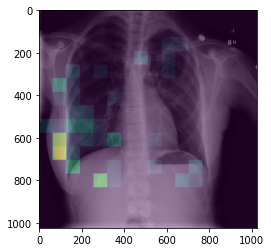

In [56]:
NUM_PATCHES = 16
row = gaze_dp[4]
heatmap = row["gaze"].to_heatmap(num_patches=NUM_PATCHES)
height, width = np.array(row["img"]).shape
plt.imshow(row["img"], cmap="gray")
plt.imshow(
    heatmap.repeat(height / NUM_PATCHES, axis=0).repeat(width / NUM_PATCHES, axis=1), 
    alpha=0.4
)

## Segmentations


In [ ]:
import cv2

def rle2mask(rle, orig_dim, resize_dim = None):
  height, width = orig_dim
  mask = np.zeros(width * height)
  array = np.asarray([int(x) for x in rle.split()])
  starts = array[0::2]
  lengths = array[1::2]
  current_position = 0
  for index, start in enumerate(starts):
    current_position += start
    mask[current_position : current_position + lengths[index]] = 1
    current_position += lengths[index]
  mask = mask.reshape(width, height)
  if resize_dim is not None:
    mask = cv2.resize(mask, resize_dim, interpolation=cv2.INTER_CUBIC)
  return mask

def normalize(img):
  img = img.permute((1, 2, 0))
  return (img - torch.min(img)) / (torch.max(img) - torch.min(img))

# plt.imshow(normalize(dp_train["img"][0]))
x = dp_train["img"][1]
_, ax = plt.subplots(1,1, figsize=(5,5))
ax.imshow(x, cmap="gray")
mask = rle2mask(dp_train["encoded_pixels"][1], (1024, 1024))
mask[mask == 0] = np.nan
ax.imshow(mask, alpha=0.6)